### 목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를 생성하여 회귀분석을 실시하고 결과를 해석하라.
(BMI 계산 시, WEIGHT는 파운드(1b : 0.45kg), HEIGHT는 인치(1inch : 2.54cm) 이므로 변환하여 사용)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### 1. 데이터 구성하기

In [109]:
df_raw = pd.read_csv('/home/pirl/Downloads/data2_py/체질검사.csv')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [110]:
#요약 통계량
df_raw.describe().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000
mean,19.151,44.885,178.924,70.149,37.992,100.824,92.556,99.905,59.406,38.590,23.102,32.273,28.664,18.230
std,8.369,12.602,29.389,3.663,2.431,8.430,10.783,7.164,5.250,2.412,1.695,3.021,2.021,0.934
min,0.000,22.000,118.500,29.500,31.100,79.300,69.400,85.000,47.200,33.000,19.100,24.800,21.000,15.800
25%,12.475,35.750,159.000,68.250,36.400,94.350,84.575,95.500,56.000,36.975,22.000,30.200,27.300,17.600
50%,19.200,43.000,176.500,70.000,38.000,99.650,90.950,99.300,59.000,38.500,22.800,32.050,28.700,18.300
75%,25.300,54.000,197.000,72.250,39.425,105.375,99.325,103.525,62.350,39.925,24.000,34.325,30.000,18.800
max,47.500,81.000,363.150,77.750,51.200,136.200,148.100,147.700,87.300,49.100,33.900,45.000,34.900,21.400


In [111]:
#파생변수(BMI : 체질량 지수)생성 (단위에 주의해야 한다!)
df_raw['BMI'] = ((df_raw['WEIGHT']*0.45)/(df_raw['HEIGHT']*0.0254)**2)

In [112]:
#생성된 파생변수 확인하기
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


In [113]:
#다중공선성의 문제를 해결하기 위해 BMI 생성에 사용했던 WEIGHT,HEIGHT를 제거
df_raw = df_raw.drop(['WEIGHT','HEIGHT'],axis=1)

In [114]:
#결측치 확인
df_raw.isnull().sum()

FAT        0
AGE        0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
BMI        0
dtype: int64

결측치는 없다.

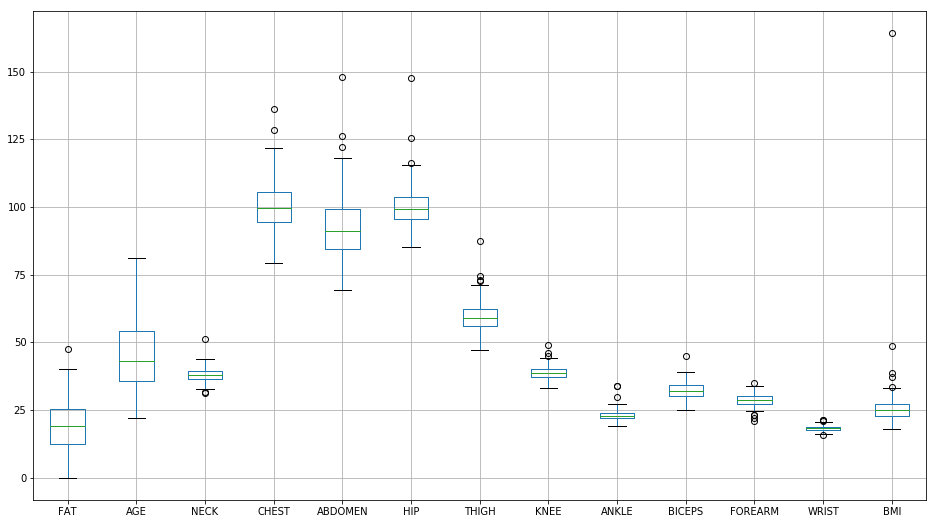

In [115]:
#이상치 확인
df_raw.boxplot(figsize=(16,9))

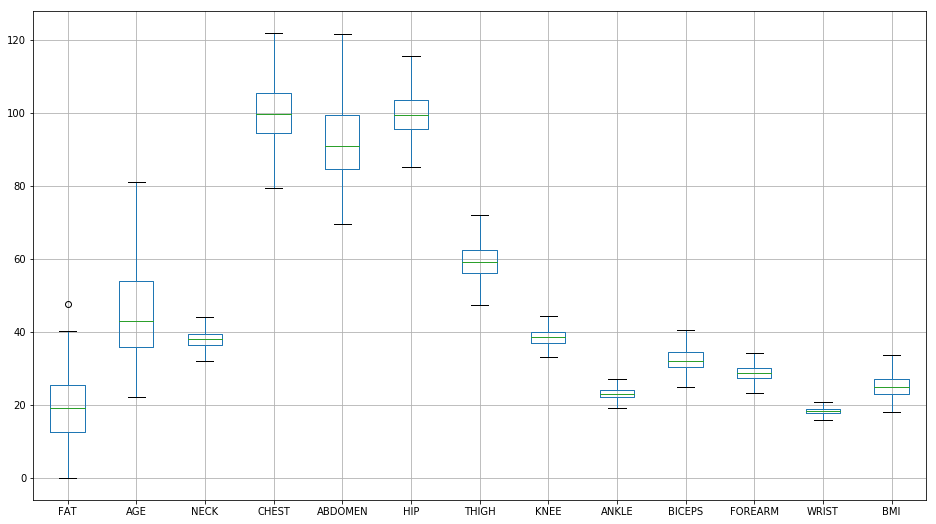

In [116]:
# 이상치 조정
for i in range(1, 13, 1) :
   num1, num2 = np.percentile(df_raw.iloc[:,[i]], [25, 75])
   iqr_max = num2 + 1.5 * (num2- num1)
   iqr_min = num1 - 1.5 * (num2- num1)
   for j in range(0, len(df_raw.iloc[:,[i]])) :
       if (df_raw.iloc[j,i] > iqr_max):
           df_raw.iloc[j,i] = iqr_max
       elif (df_raw.iloc[j,i] < iqr_min) :
           df_raw.iloc[j,i] = iqr_min

df_raw.boxplot(figsize=(16,9))

#### 2. 변수간의 경향성 파악

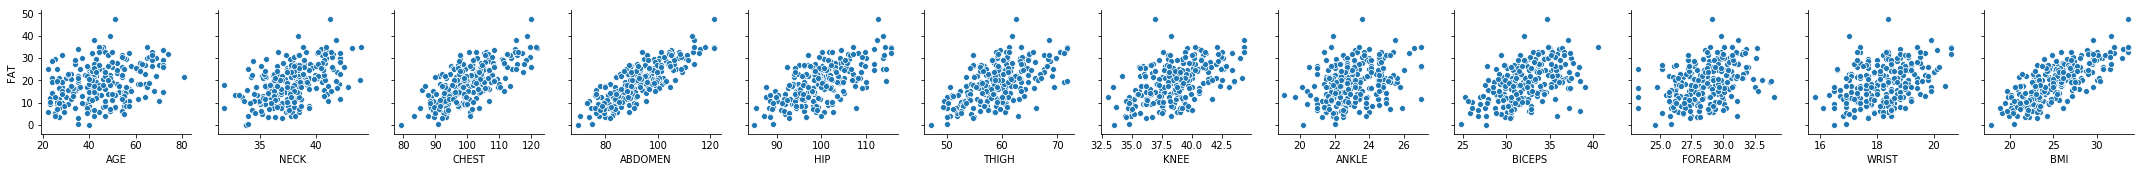

In [118]:
#산점도행렬 그리기
sns.pairplot(df_raw, y_vars='FAT', x_vars=['AGE','NECK','CHEST',\
                                           'ABDOMEN','HIP','THIGH','KNEE','ANKLE',\
                                           'BICEPS','FOREARM','WRIST','BMI'])

* 목표변수(체질 비만도, FAT)와 다수(WEIGTH,CHEST,ABDOMEN 등)의 설명변수간의 선형관계를 확인할 수 있다.
* 이상치도 확인할 수 있지만 자세한 사항은 다음 이상치 확인 부분에서 하도록 한다.

In [119]:
#상관계수 분석
df_raw.corr().round(3)

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.291,0.493,0.707,0.828,0.646,0.564,0.506,0.307,0.492,0.374,0.340,0.752
AGE,0.291,1.000,0.118,0.182,0.240,-0.058,-0.210,0.013,-0.141,-0.043,-0.087,0.215,0.123
NECK,0.493,0.118,1.000,0.774,0.734,0.702,0.667,0.653,0.539,0.717,0.678,0.743,0.751
CHEST,0.707,0.182,0.774,1.000,0.911,0.821,0.712,0.711,0.548,0.718,0.616,0.644,0.908
ABDOMEN,0.828,0.240,0.734,0.911,1.000,0.860,0.745,0.724,0.512,0.669,0.543,0.601,0.912
HIP,0.646,-0.058,0.702,0.821,0.860,1.000,0.889,0.832,0.634,0.730,0.615,0.608,0.865
THIGH,0.564,-0.210,0.667,0.712,0.745,0.889,1.000,0.792,0.635,0.749,0.616,0.541,0.805
KNEE,0.506,0.013,0.653,0.711,0.724,0.832,0.792,1.000,0.710,0.665,0.594,0.661,0.719
ANKLE,0.307,-0.141,0.539,0.548,0.512,0.634,0.635,0.710,1.000,0.547,0.537,0.652,0.555
BICEPS,0.492,-0.043,0.717,0.718,0.669,0.730,0.749,0.665,0.547,1.000,0.714,0.625,0.741


* 목표변수(FAT)와 가슴둘레(CHEST),복부둘레(ABDOMEN)간의 높은 상관계수로부터 높은 선형관계를 확인할 수 있다.
* 뿐만 아니라, 설명변수 간의 선형관계도 확인이 되기때문에 다중공선성 확인 및 처리가 필요하다.

#### 3. 다중공선성 확인

In [120]:
df_raw_x = df_raw.drop('FAT', axis=1)

df_raw_x_const = add_constant(df_raw_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
1,AGE,2.107
10,FOREARM,2.557
8,ANKLE,2.648
9,BICEPS,3.439
11,WRIST,3.493
2,NECK,3.886
7,KNEE,4.569
6,THIGH,7.495
3,CHEST,8.909
5,HIP,10.112


ABDOMEN 의 분산팽창지수가 11.268로 가장 크므로 변수의 특성과 영향을 고려하여 모델에서 제외할지를 검토해봐야 한다.

#### 4. 회귀 모델 생성

In [121]:
#ABDOMEN을 제외한 회귀분석을 실시
reg_model = smf.ols(formula = 'FAT~AGE+NECK+CHEST+HIP+THIGH+\
                               KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI',data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     42.17
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           6.35e-50
Time:                        22:22:20   Log-Likelihood:                -756.88
No. Observations:                 252   AIC:                             1538.
Df Residuals:                     240   BIC:                             1580.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.2280      8.635     -2.343      0.0

In [122]:
#ABDOMEN을 제거한 후 다중공선성 재확인
df_raw_x = df_raw.drop(['FAT','ABDOMEN'], axis=1)

df_raw_x_const = add_constant(df_raw_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values('VIF',inplace=True)
df_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
1,AGE,1.821
9,FOREARM,2.521
7,ANKLE,2.642
8,BICEPS,3.401
10,WRIST,3.476
2,NECK,3.853
6,KNEE,4.569
3,CHEST,7.367
5,THIGH,7.467
4,HIP,8.749


* 모든 VIF 값이 10보다 작으므로 다중공선성은 거의 해결되었다고 할 수 있다.
* 이제 회귀모델에서의 회귀계수 검정을 실시한다.

In [123]:
#p-value 값이 가장 커서 유의하지 않다는 결과가 나온 FOREARM 변수를 제외한 회귀분석을 실시
reg_model = smf.ols(formula = 'FAT~AGE+NECK+CHEST+ABDOMEN+THIGH+\
                               ANKLE+BICEPS+WRIST+BMI',data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     80.92
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           7.07e-68
Time:                        22:23:42   Log-Likelihood:                -717.48
No. Observations:                 252   AIC:                             1455.
Df Residuals:                     242   BIC:                             1490.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5607      6.815     -0.376      0.7

In [124]:
#ANKLE 변수를 제외한 회귀분석을 실시
reg_model = smf.ols(formula = 'FAT~AGE+NECK+CHEST+ABDOMEN+\
                               BICEPS+WRIST+BMI',data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     104.9
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           6.88e-70
Time:                        22:24:03   Log-Likelihood:                -717.51
No. Observations:                 252   AIC:                             1451.
Df Residuals:                     244   BIC:                             1479.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2064      6.111     -0.525      0.6

In [125]:
#BICEPS 변수를 제외한 회귀분석을 실시
reg_model = smf.ols(formula = 'FAT~AGE+NECK+CHEST+ABDOMEN+\
                               WRIST+BMI',data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     122.1
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.05e-70
Time:                        22:24:39   Log-Likelihood:                -718.10
No. Observations:                 252   AIC:                             1450.
Df Residuals:                     245   BIC:                             1475.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4125      6.110     -0.559      0.5

In [126]:
#NECK 변수를 제외한 회귀분석을 실시
reg_model = smf.ols(formula = 'FAT~AGE+CHEST+ABDOMEN+\
                               WRIST+BMI',data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     145.0
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           3.03e-71
Time:                        22:25:02   Log-Likelihood:                -719.44
No. Observations:                 252   AIC:                             1451.
Df Residuals:                     246   BIC:                             1472.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6415      5.972     -0.945      0.3

* 위의 분산분석의 F-검정 결과를 보면, p-value가 0.05보다 작으므로 신뢰수준 95%내에서 위의 회귀모델은 유의하다.
* 또한, 수정된 결정계수는 0.742로 전체 변동 중에서 모델에 의해 설명되는 변동을 74.2% 설명한다고 할 수 있다.
* 또한 회귀계수에 대한 t통계량 p-value값이 모두 0.05보다 작으므로 유의하다고 할 수 있다.

### 5. 잔차분석

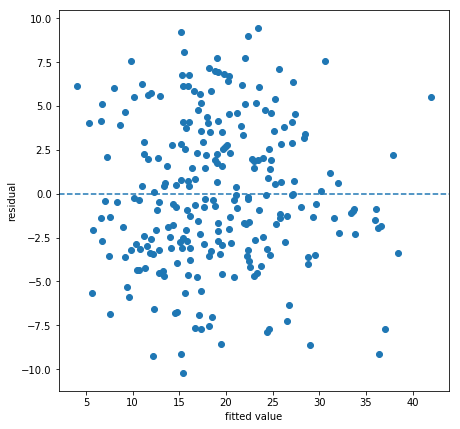

In [127]:
#등분산성 검정
plt.figure(figsize=(7, 7))

plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")

잔차들의 흩어진 모양이 전체적으로 고르기 때문에 등분산성을 만족한다고 할 수 있다.

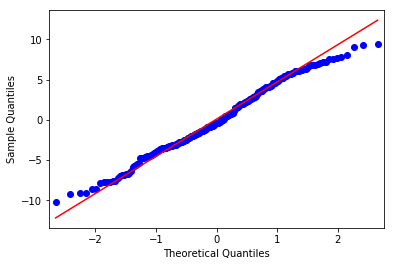

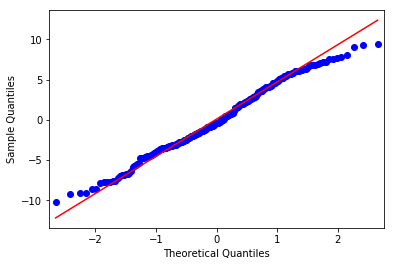

In [128]:
#정규성 검정

qqplot(reg_result.resid, line="q")

직선 주위에 데이터가 밀집되어 있기 때문에 정규성을 만족한다고 할 수 있다.

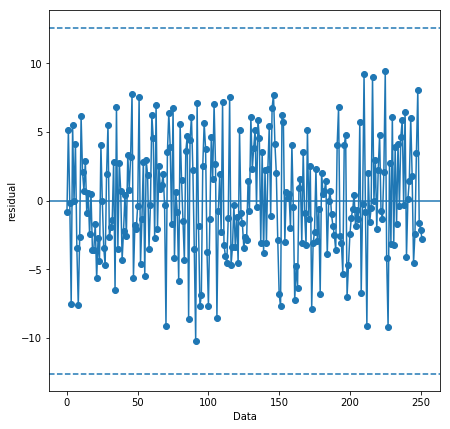

In [129]:
#독립성 검정
plt.figure(figsize=(7, 7))
plt.plot(df_raw.index, reg_result.resid, marker="o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="-")
plt.axhline(y=3*np.std(reg_result.resid), linestyle="--") #+-3시그마 로 그리기
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="--")

가로축의 변화에 따라 일정한 패턴없이 잔차의 값이 변하고 있으므로 독립성을 만족한다고 할 수 있다.

### 6. 결론

체질비만도는 나이, 가슴둘레, 복부둘레, 손목둘레, 그리고 체질량 지수로 설명될 수 있다. 그 중에서도 체질비만도는 손목둘레의 영향을 많이 받는다는 결과가 나왔는데, 손목둘레가 크면 클수록 체질비만도가 낮아진다고 할 수 있다. 그 다음 복부둘레는 크면 클수록 체질비만도는 높아진다고 할 수 있다. 또한, 위의 5가지 데이터로 체질비만도를 측정할 수 있고 이는 74%정도의 설명력을 가지므로 어느정도 신뢰성 있는 체질비만도를 예측할 수 있을 것이다.